In [350]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import train_test_split

pd.set_option('display.float_format', lambda x: '%.f' % x)
pd.set_option('display.max_rows', 100)

RANDOM_SEED = 34

In [233]:
path = r"C:\Users\flavi\Desktop\Py files\datasets\jampa_housing.csv"
data = pd.read_csv(path)

### Task

Explore the dataset and train a regression model to predict house prices.


The data was collected from OLX for the city of João Pessoa in the year 2024

In [234]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4968 entries, 0 to 4967
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              4968 non-null   int64 
 1   price           4968 non-null   object
 2   professionalAd  4968 non-null   bool  
 3   description     4968 non-null   object
 4   isFeatured      4968 non-null   bool  
 5   neighbourhood   4968 non-null   object
 6   city            4968 non-null   object
 7   date            4968 non-null   int64 
 8   category        4968 non-null   object
 9   iptu            4317 non-null   object
 10  size            4729 non-null   object
 11  rooms           4968 non-null   object
 12  bathrooms       4945 non-null   object
 13  garage_spaces   4646 non-null   object
dtypes: bool(2), int64(2), object(10)
memory usage: 475.6+ KB


In [235]:
data.rename(columns={'size': 'area'}, inplace=True)

The dataset also contains data for the municipality of Cabedelo, which is not what we are interested in, let's filter it out

In [236]:
data = data[data.city == "João Pessoa"]

#### Handling missing data and cleaning outliers

From previous works, we know that the most important features for this task is area in m².

We cannot use entries that don't contain area information, and filling this data using any method could lead to noise

We drop these entries with missing area and price (or zero) and filter for the minimum area of 10m² and price of 10000

We use the IQR range to drop outliers of area and price, however we want to allow for a wider range of areas so we use a more lenient multiplier

We also drop the ad id column

The remaining columns with missing data can be filled with the most common values

convert the columns to float

In [237]:
def str_to_float(x):
    if not x or x is None:
        return 0
    numeric_str = re.sub(r'[^0-9-]', '', str(x))
    return float(numeric_str if len(numeric_str) else "0")

In [238]:
data.dropna(subset=['area'], inplace=True)
data["price"] = data["price"].apply(str_to_float)
data["area"] = data["area"].apply(str_to_float)

data = data[(data['area'] > 10) & (data['price'] > 10000)]

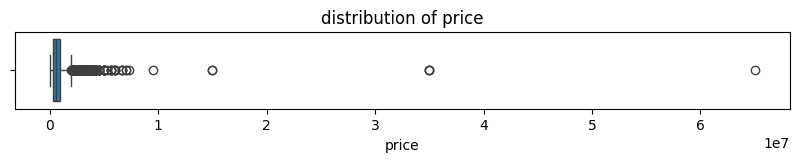

In [239]:
plt.figure(figsize=(10,1))
plt.title("distribution of price")
sns.boxplot(x=data['price'],showfliers=True)
plt.show()

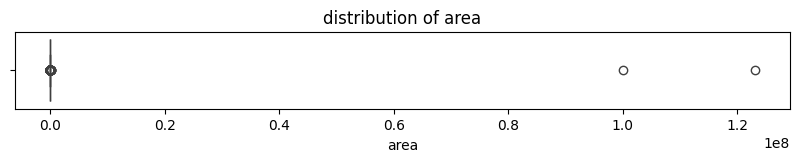

In [240]:
plt.figure(figsize=(10,1))
plt.title("distribution of area")
sns.boxplot(x=data['area'],showfliers=True)
plt.show()

In [241]:
for col in ["area", "price"]:
    multiplier = 2.5
    IQR = data[col].quantile(0.75) - data[col].quantile(0.25)
    threshold = data[col].median() + (IQR * multiplier)
    # data.loc[data[col] > threshold, col] = threshold   ## this would curb the outliers at the threshold
    print(f"Number of outliers, {col} : {data[data[col] > threshold].shape[0]}")
    data = data[data[col] <= threshold]

Number of outliers, area : 101
Number of outliers, price : 252


In [242]:
data[["area", "price"]].describe()

,area,price
count,4089,4089
mean,184,629514
std,113,469243
min,12,25000
25%,100,270000
50%,170,497000
75%,247,850000
max,625,2200000


To double check that the data was collected correctly, let's check the website for a second and pick the examples for the min and max values

#### Price min and max
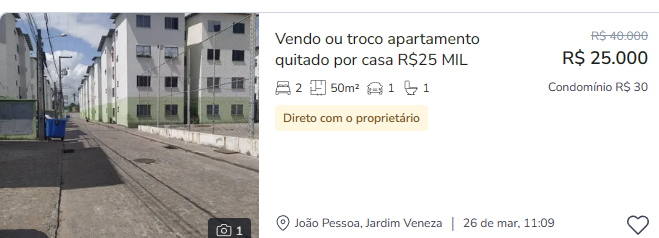
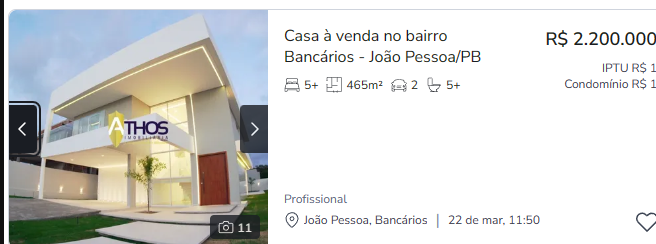)

#### Area min and max
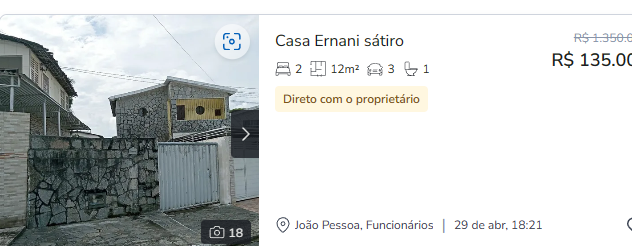
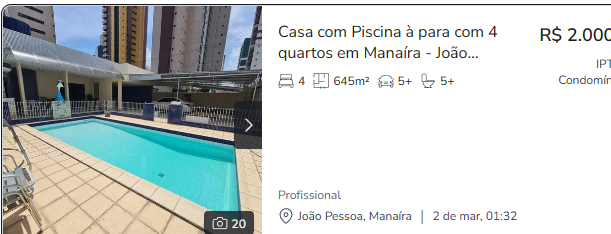

It seems the data is was collected correctly

In [243]:
data.shape

(4089, 14)

In [244]:
columns_to_fill = ["bathrooms", "garage_spaces", "iptu",]
for column in columns_to_fill:
    most_common_value = data[column].mode()[0]
    data[column].fillna(most_common_value, inplace=True)

converting the remaing columns. Notice how the 5 or more will become just 5, but this is the data that we have

In [245]:
data['date'] = pd.to_datetime(data['date'], unit='s').dt.date
data["iptu"] = data["iptu"].apply(str_to_float)
data["rooms"] = data["rooms"].apply(str_to_float)
data["bathrooms"] = data["bathrooms"].apply(str_to_float)
data["garage_spaces"] = data["garage_spaces"].apply(str_to_float)

In [246]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4089 entries, 0 to 4967
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              4089 non-null   int64  
 1   price           4089 non-null   float64
 2   professionalAd  4089 non-null   bool   
 3   description     4089 non-null   object 
 4   isFeatured      4089 non-null   bool   
 5   neighbourhood   4089 non-null   object 
 6   city            4089 non-null   object 
 7   date            4089 non-null   object 
 8   category        4089 non-null   object 
 9   iptu            4089 non-null   float64
 10  area            4089 non-null   float64
 11  rooms           4089 non-null   float64
 12  bathrooms       4089 non-null   float64
 13  garage_spaces   4089 non-null   float64
dtypes: bool(2), float64(6), int64(1), object(5)
memory usage: 423.3+ KB


In [247]:
data.head()

,id,price,professionalAd,description,isFeatured,neighbourhood,city,date,category,iptu,area,rooms,bathrooms,garage_spaces
0,1298664394,880000,False,Vendo Casa em João Pessoa - PB,True,Miramar,João Pessoa,2024-05-05,Casas,1560,410,5,4,4
1,1301922309,1100000,True,"Casa para Venda em João Pessoa, Tambauzinho, 3...",False,Tambauzinho,João Pessoa,2024-05-05,Casas,0,220,3,4,4
2,1301922248,750000,True,"Casa para Venda em João Pessoa, Miramar, 4 dor...",False,Miramar,João Pessoa,2024-05-05,Casas,0,378,4,3,1
3,1301922218,750000,True,"Casa para Venda em João Pessoa, Tambauzinho, 4...",False,Tambauzinho,João Pessoa,2024-05-05,Casas,0,340,4,5,2
4,1301922118,1200000,True,"Casa para Venda em João Pessoa, Manaíra, 5 dor...",False,Manaíra,João Pessoa,2024-05-05,Casas,0,300,5,4,2


### Exploring the data

with the data clean and outliers handled, we can begin exploring

In [248]:
data.drop("id", axis=1).describe()

,price,iptu,area,rooms,bathrooms,garage_spaces
count,4089,4089,4089,4089,4089,4089
mean,629514,224,184,3,2,2
std,469243,7180,113,1,1,1
min,25000,0,12,0,0,0
25%,270000,0,100,3,1,1
50%,497000,0,170,3,2,2
75%,850000,0,247,4,3,3
max,2200000,350000,625,5,5,5


Which are more common in the dataset, houses or apartments?

In [249]:
data.category.value_counts()

category
Casas           3653
Apartamentos     436
Name: count, dtype: int64

Looking at the neighbourhoods

In [250]:
print(data.neighbourhood.unique().size,
data.neighbourhood.value_counts())

62 neighbourhood
Muçumagro                      388
Portal do Sol                  290
Gramame                        242
José Américo de Almeida        224
Jardim Cidade Universitária    195
Ernesto Geisel                 191
Cristo Redentor                187
Mangabeira                     178
Bancários                      139
Estados                        126
Altiplano Cabo Branco          116
Bessa                          112
Manaíra                        104
Valentina de Figueiredo         99
Paratibe                        81
Brisamar                        77
Funcionários                    76
Jardim Oceania                  74
Torre                           68
Treze de Maio                   63
Jaguaribe                       63
Tambaú                          58
Tambauzinho                     57
Aeroclube                       56
Centro                          53
Cabo Branco                     51
Castelo Branco                  51
Água Fria                       47
Cui

In [251]:
#which neighbourhoods are the most expensive?

print(data.groupby("neighbourhood")["price"].median().reset_index().sort_values("price", ascending=False).reset_index(drop=True))

                  neighbourhood   price
0         Altiplano Cabo Branco 1550000
1                Jardim Oceania 1100000
2                 Portal do Sol 1090000
3                   Cabo Branco  950000
4                       Manaíra  850000
5                         Bessa  840000
6               Ponta do Seixas  800000
7                   Tambauzinho  799000
8                        Tambaú  790450
9                       Miramar  750000
10                      Estados  739950
11                    Muçumagro  739000
12                     Brisamar  690000
13                 Pedro Gondim  650000
14              Expedicionários  650000
15                    Bancários  600000
16             Jardim São Paulo  594500
17                    Aeroclube  573646
18  Jardim Cidade Universitária  550000
19                     Anatólia  527500
20                         Ipês  488500
21                João Agripino  480000
22                    Água Fria  450000
23                Treze de Maio  450000


checking linearity assumptions

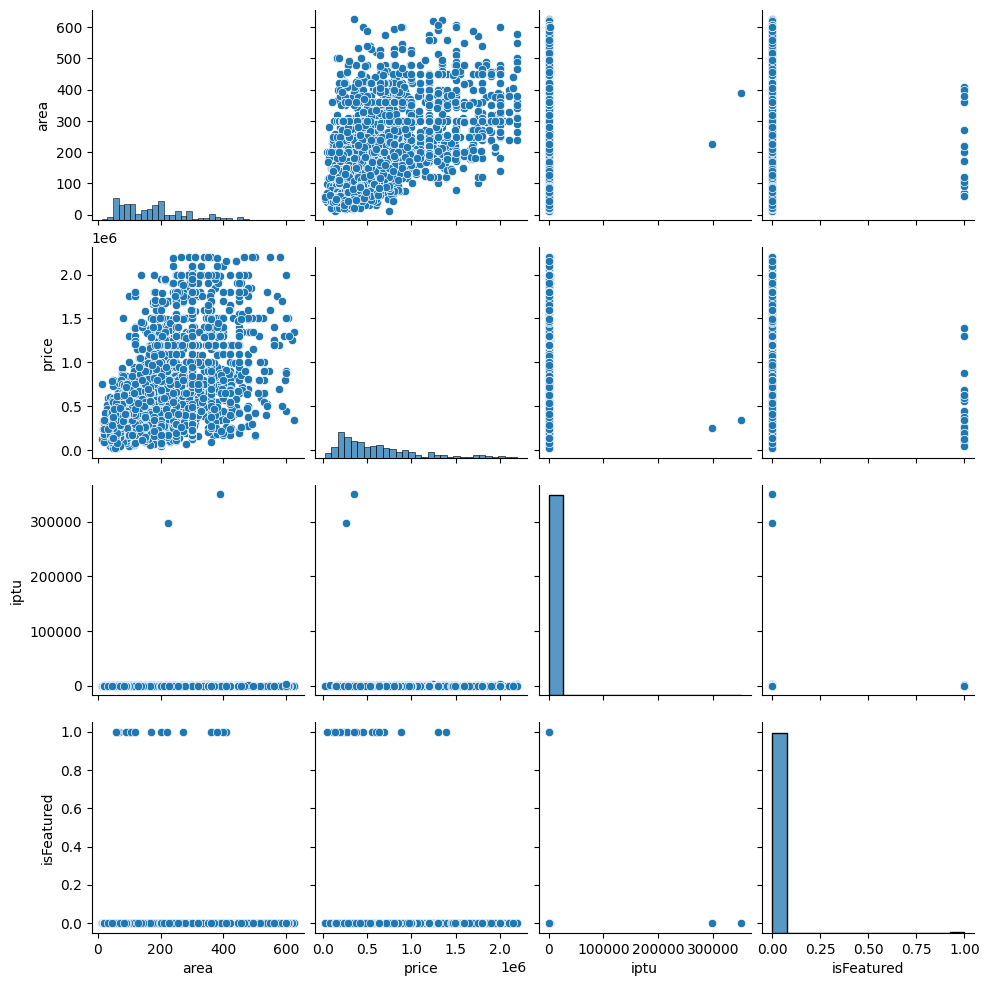

In [252]:
sns.pairplot(data[["area", "price", "iptu", "category", "isFeatured", ]]);


There is no clear correlation of the main discrete features. This is expected because neighbourhood has a high influence on a house's price. So a linear model shouldn't achieve good results

#### Feature engineering


let's first take a look at the boolean features

In [253]:
data.professionalAd.value_counts()

professionalAd
True     3791
False     298
Name: count, dtype: int64

In [254]:
data.isFeatured.value_counts()

isFeatured
False    4065
True       24
Name: count, dtype: int64

it seems these features might not have enough signal, besides when using the model on new entries, they are not intrinsic characterisc of the property

and the iptu feature, which according to the municipality is related to factors including the estimated price of the property (our target variable) and the location

So this feature might need special attention

In [255]:
entries_with_valid_iptu = data[data.iptu > 0]
print(f"{entries_with_valid_iptu.shape[0]} out of {data.shape[0]} entries have valid IPTU")

880 out of 4089 entries have valid IPTU


we could fix the obvious 2 rows where the saler input wrong values, but using the median will suffice to get a reasonable tax %

In [256]:
entries_with_valid_iptu["IPTUtax"] = entries_with_valid_iptu.iptu / (entries_with_valid_iptu.price / 10000)
entries_with_valid_iptu.head()

C:\Users\flavi\AppData\Local\Temp\ipykernel_30432\3821548498.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entries_with_valid_iptu["IPTUtax"] = entries_with_valid_iptu.iptu / (entries_with_valid_iptu.price / 10000)


,id,price,professionalAd,description,isFeatured,neighbourhood,city,date,category,iptu,area,rooms,bathrooms,garage_spaces,IPTUtax
0,1298664394,880000,False,Vendo Casa em João Pessoa - PB,True,Miramar,João Pessoa,2024-05-05,Casas,1560,410,5,4,4,18
8,1301322913,750000,True,"Casa para Venda em João Pessoa, Tambauzinho, 4...",False,Tambauzinho,João Pessoa,2024-05-03,Casas,760,231,4,5,4,10
20,1298863190,380000,True,"Casa para Venda em João Pessoa, Cristo, 3 dorm...",False,Cristo Redentor,João Pessoa,2024-04-23,Casas,450,180,3,2,3,12
34,1293054823,280000,True,"Casa para Venda em João Pessoa, Cristo, 3 dorm...",False,Cristo Redentor,João Pessoa,2024-04-02,Casas,350,300,3,1,2,12
56,1288611690,170000,False,Casa Terreno de Esquina - 361 m² - Cuiá - Vale...,False,Valentina de Figueiredo,João Pessoa,2024-04-13,Casas,180,366,2,1,3,11


In [257]:
print(entries_with_valid_iptu.groupby("neighbourhood")["IPTUtax"].median().reset_index().sort_values("IPTUtax", ascending=False).reset_index(drop=True))

                  neighbourhood  IPTUtax
0        Planalto Boa Esperança       23
1                   Alto do Céu       16
2                Cruz das Armas       13
3       Valentina de Figueiredo       13
4                          Cuiá       12
5                 João Agripino       12
6                 Ernani Sátiro       11
7                        Tambiá       10
8               Ponta do Seixas       10
9                        Grotão       10
10                    Oitizeiro       10
11                      Manaíra        8
12                 Pedro Gondim        8
13                        Bessa        8
14                        Roger        7
15               Jardim Oceania        7
16                Treze de Maio        7
17                      Gramame        7
18      José Américo de Almeida        6
19                      Mumbaba        6
20                   Indústrias        6
21                  Tambauzinho        6
22                   Mangabeira        6
23              

considering that only 21% of the entries have iptu and that our tax yelded strange results, it is safer to drop iptu altogether.

 The discrepancy is probably due to owner property valuation being too diferent from the town valuation

In [399]:
# selecting the features is simpler now
features = data[["area", "neighbourhood", "rooms", "bathrooms", "garage_spaces", "category" ]]
# one hot encoding
X = pd.get_dummies(features, drop_first=True)
y = data.price
x_train, x_test, y_train, y_test = train_test_split(X, y, train_size= 0.95)
x_train.head()


,area,rooms,bathrooms,garage_spaces,neighbourhood_Altiplano Cabo Branco,neighbourhood_Alto do Céu,neighbourhood_Alto do Mateus,neighbourhood_Anatólia,neighbourhood_Bancários,neighbourhood_Barra de Gramame,...,neighbourhood_Tambaú,neighbourhood_Tambiá,neighbourhood_Torre,neighbourhood_Treze de Maio,neighbourhood_Trincheiras,neighbourhood_Valentina de Figueiredo,neighbourhood_Varadouro,neighbourhood_Varjão,neighbourhood_Água Fria,category_Casas
2722,200,3,2,2,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
219,360,3,2,4,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,True
842,423,3,4,0,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
2271,110,3,1,2,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
1691,110,3,3,2,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True


### Modeling

most likely the best models will be tree based

In [400]:
rf = RandomForestRegressor(n_estimators=150, random_state=RANDOM_SEED, max_features=3)
rf.fit(x_train, y_train)
rf_preds = rf.predict(x_test)
mean_absolute_error(y_test, rf_preds)

132699.29574096654

In [401]:
x_train

,area,rooms,bathrooms,garage_spaces,neighbourhood_Altiplano Cabo Branco,neighbourhood_Alto do Céu,neighbourhood_Alto do Mateus,neighbourhood_Anatólia,neighbourhood_Bancários,neighbourhood_Barra de Gramame,...,neighbourhood_Tambaú,neighbourhood_Tambiá,neighbourhood_Torre,neighbourhood_Treze de Maio,neighbourhood_Trincheiras,neighbourhood_Valentina de Figueiredo,neighbourhood_Varadouro,neighbourhood_Varjão,neighbourhood_Água Fria,category_Casas
2722,200,3,2,2,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
219,360,3,2,4,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,True
842,423,3,4,0,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
2271,110,3,1,2,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
1691,110,3,3,2,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,94,3,2,2,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
762,180,3,5,3,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
2054,311,4,5,2,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
2816,102,3,3,2,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True


In [402]:
xgb0 = XGBRegressor(n_estimators=200, learning_rate=0.5, random_state=RANDOM_SEED)
xgb0.fit(x_train, y_train)
xgb_preds = xgb0.predict(x_test)
mean_absolute_error(y_test, xgb_preds)

147168.0032202744

Hyper parameterer tunning

In [403]:
param_dist = {
    'n_estimators': range(100, 1001, 100),
    'max_features': [2, 3, 'auto', 'sqrt'],
    'max_depth': [None] + list(range(2, 31, 5)),
    'min_samples_split': range(2, 11),
    'min_samples_leaf': range(1, 11),
    'bootstrap': [True, False]
}

scoring = ["neg_mean_absolute_error", 'neg_mean_squared_error']
rfr = RandomForestRegressor(random_state = RANDOM_SEED)

# Instantiate the GridSearchCV object
rfr_cv = RandomizedSearchCV(rfr, param_dist, scoring=scoring, cv=5, refit='neg_mean_absolute_error', n_jobs= -1)
rfr_cv.fit(x_train, y_train)
rfr_cv.best_params_

c:\Users\flavi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
5 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\flavi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\flavi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "c:\Users\flavi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py",

{'n_estimators': 800,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 27,
 'bootstrap': False}

In [404]:
best_rf = rfr_cv.best_estimator_
best_rf.fit(x_train, y_train)
best_rf_preds= best_rf.predict(x_test)
mean_absolute_error(y_test, best_rf_preds)

135442.00702397025

In [405]:
param_dist = {
    'learning_rate':np.arange(0.01, 0.51, 0.01),
    'n_estimators': range(100, 1001, 100),
    'max_depth': range(3, 11),
    'min_child_weight': range(1, 11),
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
}
scoring = ["neg_mean_absolute_error", 'neg_mean_squared_error']
xgb = XGBRegressor(random_state = RANDOM_SEED)

# Instantiate the GridSearchCV object
xgb_cv = RandomizedSearchCV(xgb, param_dist, scoring=scoring, cv=5, refit='neg_mean_absolute_error', n_jobs= -1,  random_state=RANDOM_SEED)
xgb_cv.fit(x_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 ]),
                                        'max_depth': range(3, 11),
                                        'min_child_weight': range(1, 11),
                                        'n_estimators': range(100, 1001, 100),
                                        'subsample': [0.6, 0.7, 0.8, 0.9, 1.0]},
                   random_state=34, refit='neg_mean_absolute_error',
                   scoring=['neg_mean_absolute_error',
                            'neg_mean_squared_error'])

In [406]:
xgb_cv.best_params_

{'subsample': 0.9,
 'n_estimators': 100,
 'min_child_weight': 2,
 'max_depth': 7,
 'learning_rate': 0.39}

In [407]:
best_xgb = xgb_cv.best_estimator_
best_xgb.fit(x_train, y_train)
best_xgb_preds= best_xgb.predict(x_test)
mean_absolute_error(y_test, best_xgb_preds)

138654.0597942073

Comparing some values

In [412]:
selected_model = best_xgb
num_entries = 15
preds = selected_model.predict(x_test)[:num_entries]
real_values = y_test[:num_entries]
comparison = list(zip(preds, real_values))
for v in comparison:
    print(f"predicted : {round(v[0], 2)}   real : {v[1]}")

predicted : 662014.625   real : 629990.0
predicted : 361238.6875   real : 250000.0
predicted : 1485742.125   real : 1799000.0
predicted : 643364.0625   real : 480000.0
predicted : 391378.46875   real : 450000.0
predicted : 1680636.5   real : 1750000.0
predicted : 111477.421875   real : 35000.0
predicted : 975427.8125   real : 1299000.0
predicted : 250691.421875   real : 255000.0
predicted : 917960.1875   real : 1390000.0
predicted : 197662.78125   real : 190000.0
predicted : 203217.921875   real : 229999.0
predicted : 597196.0625   real : 680000.0
predicted : 1227019.125   real : 790000.0
predicted : 482834.375   real : 560000.0


In [433]:
def create_array(area: float, rooms: int, bathrooms: int, garage_spaces: int, neighbourhood: str, isCasa: bool) -> np.ndarray:
       columns = list(X.columns)
       if f"neighbourhood_{neighbourhood}" not in columns[4:]:
              raise ValueError("Invalid neighbourhood")

       array = np.array([area, rooms, bathrooms, garage_spaces])
       array = np.append(array, np.zeros(len(columns) - 4))
       idx = columns.index(f"neighbourhood_{neighbourhood}")
       array[idx] = 1
       array[-1] = isCasa
       return array

In [494]:
entry = create_array(180, 4, 2, 1, "Torre", 1)
print(f"predicted value : R$ {round(selected_model.predict([entry])[0], 2)}")

predicted value : R$ 346807.71875
